In [158]:
import numpy as np
import pandas as pd
import re
import os

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import PreTrainedTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from tqdm import tqdm
import time
import math


## Prerequisits

* make sure to download and unzip the data files (train,test,test_labels) from [this link](https://drive.google.com/file/d/1NuZ5i6EhRopsy8ngwhRZyQWUPHGsSIWM/view?usp=sharing)
* it's recommended that you creata a new `conda environment` by running `conda env --name ENV_NAME` replacing the `ENV_NAME` with a name of your choice, and install the `requirments.txt` by executing `pip install -r requirments.txt`
* ℹ️ if you don't want to train the model from scratch, download the `pretrained_bilstm_attn` model from [here](https://drive.google.com/file/d/1NsO26I_VTvnqiJFAVA8J7zECZCB8ONI7/view?usp=sharing)


## 1. Explanatory Data Analysis

visualize the data and understand the distributions 

 ### importing the data from the csv files

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
y_true = pd.read_csv('test_labels.csv')

 ### have an idea about the length of the comments strings

In [3]:
train_df['number_of_words'] = train_df.comment_text.apply(lambda x: len(x.split()))

In [4]:
train_df.sort_values(by=['number_of_words'],ascending=False)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_of_words
140904,f207ed074493db15,I AM AN LOSER ==== I AM AN LOSER == == I AM AN...,1,0,0,0,0,0,1411
4712,0c7c341727488579,do go fuck off bastard\nDo Yyou Have a life?\n...,1,1,1,1,1,0,1403
81295,d970953f86f34327,Take that! \n\nIN THE ASS IN THE ASS IN THE AS...,1,1,1,0,0,0,1354
35817,5fb52a42944da282,What is rong with you u pervert i ahte u just ...,1,0,1,0,1,0,1344
136531,da687d5226bff7f3,SUCK MY COCK D SUCK MY COCK D SUCK MY COCK D S...,1,1,1,0,1,0,1250
...,...,...,...,...,...,...,...,...,...
52475,8c5f7911d56a9a58,User_talk:Blackson#Religious_bias,0,0,0,0,0,0,1
19815,3452aa44f93b7ee1,(www.ebenefits.va.gov),0,0,0,0,0,0,1
130194,b8878c41e3ea8203,hyper_individualist@yahoo.com,0,0,0,0,0,0,1
93586,fa3a30a329e87055,{{unblock|yo,0,0,0,0,0,0,1


As we can see, a lot of comments are of length 1,2 and 3 etc.. these are all columns we can drop from the dataset
as they will usually not play an important role in training the model.
we will drop comments of length less than 5.

In [5]:
train_df = train_df[train_df['number_of_words']>5]

In [6]:
train_df.shape

(152007, 9)

Next we can start cleaning some parts of the comments (removing URLs etc)

In [7]:
train_df[train_df.comment_text.str.contains(r"^https?:\/\/.*[\r\n]*")].shape

(116, 9)

this part was skipped (will be done later due to troubles in the dataset)

### drop the number_of_words column
we don't need this column anymore, we will drop it 

In [8]:
train_df = train_df.drop(labels=['number_of_words'],axis='columns')

### get the column names for the target variables 
these will be used later to create the train,dev and test dataset

In [9]:
cols_target = train_df.columns[2:].tolist()

### checkout the negative labels percentage in the dataset

In [10]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  90.04387955817825


### check if and row doet not have comment_text 

In [11]:
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [12]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [13]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment

,id,comment_text


### checking the labels and rows counts 

In [14]:
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 152007
toxic            14234
severe_toxic      1447
obscene           7760
threat             462
insult            7268
identity_hate     1306
dtype: int64


### visualize the labels correlation

In [15]:
train_df_corr= train_df[cols_target].corr()

In [16]:
mask = np.triu(np.ones_like(train_df_corr, dtype=np.bool))

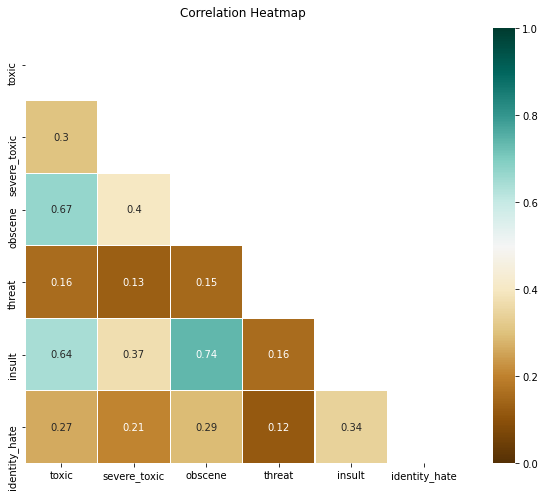

In [17]:
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(train_df_corr,mask=mask, linewidths=0.1, vmin=0, vmax=1,cmap='BrBG',annot=True,square=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


As we can see from the heatmap above, labels like `Toxic`,`Insult` and `Obscene` are highlt coorelated compared to other labels (i.e. they appear as labels for comments much often than the other comments)

## 2. Deep Learning part (BiLSTM with Attention & Binary Relevance)


the structure of the model is shown below, a BiLSTM with Attention model was used to implement this task of multi-label classification

there are a total of 6 models (one for each label) in the final model, following the binary relevance method to solve multi-label classification
<img src="./bilstm_attn.jpeg" width="800" >


 ### Preprocessing 
 
the tokenizer `PreTrainedTokenizerFast` was used to tokenize and transform the sequences into integer sequences which we will use later to index and Embedding Matrix 

In [18]:
tokenizer = PreTrainedTokenizerFast.from_pretrained('bert-base-uncased')


In [19]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [20]:
def prepare_set(dataset, max_length=64):
    """returns input_ids, input_masks, labels for set of data ready in BERT format"""
    global tokenizer
    
    input_ids = dataset
#     for i in tqdm(dataset):
#         input_ids.append(camel_case_split(i))
    tokenized = tokenizer.batch_encode_plus(input_ids,return_token_type_ids=False, return_attention_mask=False, pad_to_max_length=True,truncation=True, max_length=max_length)["input_ids"]
    return tokenized

### hyperparameters


In [51]:
max_length = 64
hidden_size=64
batch_size = 32
n_epochs = 4
embed_size = 64
lr = 0.001
model_path = "BiLSTM_attention_BiRel.pt"
use_gpu = True
dev_size = int(train_df.shape[0] * 0.10)

### checking if there exists a GPU on the machine to use it


In [22]:
#device config
device =  torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')

In [23]:
class Attention(nn.Module):
    """a Single Attention Layer"""
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        
        self.supports_masking = True
        self.feature_dim = feature_dim
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
    
    def forward(self, x, step_dim, mask=None):
        feature_dim = self.feature_dim
        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), self.weight
        ).view(-1, step_dim)
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        if mask is not None:
            a = a * mask
        a = a / torch.sum(a, 1, keepdim=True) + 1e-10
        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1), torch.unsqueeze(a, -1)


class BiLSTMWithAttention(nn.Module):
    """the BiLSTM model refer to the image above to understand the structure of the model"""
    def __init__(self,hidden_size,embed_size,max_features,num_classes,max_length):
        super().__init__()
        self.embedding = nn.Embedding(max_features, embed_size)
        self.lstm1 = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm_attention = Attention(hidden_size * 2)
        
        self.linear1 = nn.Linear(hidden_size*6, hidden_size*6)
        self.linear2 = nn.Linear(hidden_size*6, hidden_size*6)
        
        self.linear_out = nn.Linear(hidden_size*6, 1)
        self.linear_aux_out = nn.Linear(hidden_size*6, num_classes)
    
    def forward(self, x, step_len):
        h_embedding = self.embedding(x)
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        #Attention layer
        h_lstm_atten, weights = self.lstm_attention(h_lstm2, max_length)
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        h_conc = torch.cat((h_lstm_atten, max_pool, avg_pool), 1)
        h_conc_linear1 = F.relu(self.linear1(h_conc))
        h_conc_linear2 = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
#         out = torch.cat([result, aux_result], 1)
#         print(f"out : {out.shape}")
#         return out, weights
        return aux_result, weights


### The training Loop

* mini batching was used to increase the performance
* because this is a multi-label classification problem, a proper criterion needed to be chosen, in this case it was BCEWithLogitsLoss (which is the BCE with sigmoid implemented internally)

In [52]:
def train_model(models, loss_fn, lr=0.001, batch_size=32, n_epochs=10,max_length=64):
    for col in cols_target:
        models[col]['param_lrs'] = [{'params': param, 'lr': lr} for param in models[col]['model'].parameters()]
        models[col]['optimizer'] = torch.optim.Adam(models[col]['param_lrs'], lr=lr)
        models[col]['training_loss'] = []
        models[col]['validation_loss'] = []

    
    
    for model_index,target_label in enumerate(cols_target):
        print("="*50)
        print(f"training {target_label} model....")
        models[target_label]['model'].to(device)
        
        best_loss = float("inf")
        
        for epoch in range(n_epochs):
            start_time = time.time()

            models[target_label]['model'].train()
            avg_loss = 0

            for data in tqdm(train_dataloader, disable=False):
                x_batch = data[:-1]
                y_batch = data[-1][:,model_index].unsqueeze(1)

                y_pred, _ = models[target_label]['model'](*x_batch, max_length)
                
                loss = nn.BCEWithLogitsLoss()(y_pred,y_batch)
                models[target_label]['optimizer'].zero_grad()
                loss.backward()
                models[target_label]['optimizer'].step()
                avg_loss += loss.item() / len(train_dataloader)

            models[target_label]['training_loss'].append(avg_loss)
            models[target_label]['model'].eval()
            
            print(f'... Validating ... ')
            
            avg_val_loss = 0
            
            for val_data in tqdm(dev_dataloader, disable=False):
                x_batch = val_data[:-1]
                y_batch = val_data[-1][:,model_index].unsqueeze(1)

                y_pred, _ = models[target_label]['model'](*x_batch, max_length)

                val_loss = nn.BCEWithLogitsLoss()(y_pred, y_batch)
                avg_val_loss += val_loss.item() / len(dev_dataloader)

            elapsed_time = time.time() - start_time
            models[target_label]['validation_loss'].append(avg_val_loss)
            
            if avg_val_loss < best_loss:
                print('saving the best model so far')
                best_loss = avg_val_loss
                torch.save(models[target_label]['model'].state_dict(), target_label+'_model.pt')
            print(f'Epoch {epoch + 1}/{n_epochs}\t training_loss={avg_loss:.4f} \t validation_loss={avg_val_loss: 4f} \t time={elapsed_time:.2f}s')
    
    models.clear()
    
    models = {
        'toxic':{},
        'severe_toxic':{},
        'obscene':{},
        'threat':{},
        'insult':{},
        'identity_hate':{}
    }
    
    
    print("loading best models .... ")
    for target_label in cols_target:
        # load each best model into its corresponding dict key
        models[target_label]['model'] = BiLSTMWithAttention(hidden_size=hidden_size,
                        embed_size=embed_size,
                        max_features=tokenizer.vocab_size,
                        num_classes=1,
                        max_length=max_length)
        models[target_label]['model'].load_state_dict(torch.load(target_label+'_model.pt'))
        os.remove(target_label+'_model.pt')
    
    print("saving best models into a single file .... ")
    # saving all models in a single model file
    torch.save({
            'toxic': models['toxic']['model'].state_dict(),
            'severe_toxic': models['severe_toxic']['model'].state_dict(),
            'obscene': models['obscene']['model'].state_dict(),
            'threat': models['threat']['model'].state_dict(),
            'insult': models['insult']['model'].state_dict(),
            'identity_hate': models['identity_hate']['model'].state_dict(),
            }, model_path)
    

### The evaulating/testing part

* each time a mini batch is run through the model and the corresponding weigts are saved and column-summed to get the count of True Positive labels

In [104]:
def evaluate(models):
    for model_index,target_label in enumerate(cols_target):
        
        print("="*40)
        print(f"evaluating {target_label} model .... ")
        
        y_preds = []
        y_trues = []
        
        models[col]['model'].eval()
        with torch.no_grad():
            for tst_data in tqdm(test_dataloader, disable=False):
                x_batch = tst_data[:-1]
                y_batch_labels = tst_data[-1][:,model_index].detach().cpu().numpy()

                y_pred, _ = models[col]['model'](*x_batch, max_length)

                y_pred_labels = (torch.sigmoid(y_pred).detach().cpu().numpy() > 0.5)

                y_preds.extend(y_pred_labels.squeeze(1))
                y_trues.extend(y_batch_labels)
        
        print(confusion_matrix(y_true=y_trues,y_pred=y_preds))
        print(classification_report(y_trues,y_preds))


### Preparing the datasets

* a portion specified by dev_size is taken from the training dataframe to be used as a dev set, this would help us after each epoch to see how our model is doing (i.e. generalizing the model)
* each data is tokenized and turned into sequence ids and converted into torch.tensors

In [26]:
train_df_cpy = train_df[dev_size:]
dev_df_cpy = train_df[:dev_size]
test_df_cpy = test_df
y_true_cpy = y_true

In [27]:
print("preprocessing training data...")
X_train = prepare_set(train_df_cpy['comment_text'].values.tolist())

print("preprocessing training data...")
X_dev = prepare_set(dev_df_cpy['comment_text'].values.tolist())

print("preprocessing test data...")
test_df = pd.merge(test_df_cpy,y_true_cpy,on='id')
# -1 labels mean that those lines were not used for the scoring 
test_df = test_df[test_df["toxic"] >= 0]

X_test = prepare_set(test_df['comment_text'].values.tolist())


preprocessing training data...


/home/madbulattif18/anaconda3/envs/myenv/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


preprocessing training data...
preprocessing test data...


/home/madbulattif18/anaconda3/envs/myenv/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [28]:
y_train = train_df_cpy[cols_target].values
y_dev = dev_df_cpy[cols_target].values
y_test = test_df[cols_target].values


In [29]:
x_train_torch = torch.tensor(X_train, dtype=torch.long).to(device)
x_dev_torch = torch.tensor(X_dev, dtype=torch.long).to(device)
x_test_torch = torch.tensor(X_test, dtype=torch.long).to(device)

In [30]:
# y_train_torch = torch.tensor(np.hstack([y_train, y_aux_train]), dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train,dtype=torch.float).to(device)
y_dev_torch = torch.tensor(y_dev, dtype=torch.float).to(device)
# y_val_torch = torch.tensor(np.hstack([y_val, y_aux_val]), dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test,dtype=torch.float).to(device)

### Creating dataloaders


In [31]:
# Create the DataLoader for training set
train_data = TensorDataset(x_train_torch, y_train_torch)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [32]:
# Create the DataLoader for dev set
dev_data = TensorDataset(x_dev_torch, y_dev_torch)
dev_sampler = RandomSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

In [33]:
# Create the DataLoader for dev set.
test_data = TensorDataset(x_test_torch, y_test_torch)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [40]:
models = {
    'toxic':{},
    'severe_toxic':{},
    'obscene':{},
    'threat':{},
    'insult':{},
    'identity_hate':{}
}

In [54]:
for col in cols_target:
    models[col]['model'] = BiLSTMWithAttention(hidden_size=hidden_size,
                            embed_size=embed_size,
                            max_features=tokenizer.vocab_size,
                            num_classes=1,
                            max_length=max_length)

In [55]:
models

{'toxic': {'model': BiLSTMWithAttention(
    (embedding): Embedding(30522, 64)
    (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
    (lstm2): LSTM(128, 64, batch_first=True, bidirectional=True)
    (lstm_attention): Attention()
    (linear1): Linear(in_features=384, out_features=384, bias=True)
    (linear2): Linear(in_features=384, out_features=384, bias=True)
    (linear_out): Linear(in_features=384, out_features=1, bias=True)
    (linear_aux_out): Linear(in_features=384, out_features=1, bias=True)
  )},
 'severe_toxic': {'model': BiLSTMWithAttention(
    (embedding): Embedding(30522, 64)
    (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
    (lstm2): LSTM(128, 64, batch_first=True, bidirectional=True)
    (lstm_attention): Attention()
    (linear1): Linear(in_features=384, out_features=384, bias=True)
    (linear2): Linear(in_features=384, out_features=384, bias=True)
    (linear_out): Linear(in_features=384, out_features=1, bias=True)
    (linear_aux_out)

### Training the model

if you want to train the model from scratch, umcomment the next cell, otherwise you might opt to load the pretrained model (link shown in the prerequsits)

In [ ]:
# train models returns the trained models
#train_model(models=models,loss_fn=None,lr=lr,batch_size=batch_size,n_epochs=n_epochs,max_length=max_length)

### Loading the pretrained models
make sure that you have downloaded the model, and put it in the same directory as the notebook

In [ ]:
#loading the single file that contains the 6 models
models_single_file = torch.load(model_path)

In [75]:
# putting each model into its corresponding key in the dictionary, and load them into the GPU
for col in cols_target:
    models[col]['model'].load_state_dict(models_single_file[col])
    models[col]['model'].to(device)

### Evaluating each model on the test set

In [105]:
evaluate(models)

  1%|          | 12/2000 [00:00<00:17, 113.51it/s]

evaluating toxic model .... 


  0%|          | 0/2000 [00:00<?, ?it/s]

[[57885     3]
 [ 5977   113]]
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     57888
         1.0       0.97      0.02      0.04      6090

    accuracy                           0.91     63978
   macro avg       0.94      0.51      0.49     63978
weighted avg       0.91      0.91      0.86     63978

evaluating severe_toxic model .... 


  0%|          | 0/2000 [00:00<?, ?it/s]

[[63532    79]
 [  330    37]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     63611
         1.0       0.32      0.10      0.15       367

    accuracy                           0.99     63978
   macro avg       0.66      0.55      0.58     63978
weighted avg       0.99      0.99      0.99     63978

evaluating obscene model .... 


  0%|          | 0/2000 [00:00<?, ?it/s]

[[60264    23]
 [ 3598    93]]
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     60287
         1.0       0.80      0.03      0.05      3691

    accuracy                           0.94     63978
   macro avg       0.87      0.51      0.51     63978
weighted avg       0.94      0.94      0.92     63978

evaluating threat model .... 


  0%|          | 0/2000 [00:00<?, ?it/s]

[[63658   109]
 [  204     7]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     63767
         1.0       0.06      0.03      0.04       211

    accuracy                           1.00     63978
   macro avg       0.53      0.52      0.52     63978
weighted avg       0.99      1.00      0.99     63978

evaluating insult model .... 


  0%|          | 0/2000 [00:00<?, ?it/s]

[[60534    17]
 [ 3328    99]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     60551
         1.0       0.85      0.03      0.06      3427

    accuracy                           0.95     63978
   macro avg       0.90      0.51      0.51     63978
weighted avg       0.94      0.95      0.92     63978

evaluating identity_hate model .... 


100%|██████████| 2000/2000 [00:09<00:00, 221.48it/s]


[[63255    11]
 [  607   105]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     63266
         1.0       0.91      0.15      0.25       712

    accuracy                           0.99     63978
   macro avg       0.95      0.57      0.62     63978
weighted avg       0.99      0.99      0.99     63978



## Remarks 

* from the classification reports above we can see that our models have ~100% recall for the negative class, this is due to the negative class unbalance.
* On the other hand, the model has low recall for the positive class for each label
* although the model achieves good accuracy in predicting each label in the dataset, other hpyerparameter and modifications might be required to make it better. (adding drop, decreasing the complexity etc..)
* The attention layer fairly good to detect the part the might trigger a label.

* ⚠️ the dimenions in the figure doesn't match the trained model below, however the structure is the same, it was changed because the dimensions in the figure below caused the model to overfit


In [112]:
cols_target

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [136]:
rgb_color_shades = {
    'toxic':[(176, 58, 46),(203, 67, 53),(231, 76, 60),(236, 112, 99),(241, 148, 138),(245, 183, 177),(250, 219, 216),(253, 237, 236)],
    'severe_toxic':[(118, 68, 138) , (136, 78, 160) , (155, 89, 182) , (175, 122, 197) ,(195, 155, 211) ,(215, 189, 226) ,(235, 222, 240) ,(245, 238, 248)],
    'obscene':[(31, 97, 141), (36, 113, 163) ,(41, 128, 185), (84, 153, 199),(127, 179, 213),(169, 204, 227),(212, 230, 241),(234, 242, 248)],
    'threat':[(20, 143, 119) , (23, 165, 137) , (26, 188, 156) , (72, 201, 176),( 118, 215, 196),(163, 228, 215),(209, 242, 235),(232, 248, 245)],
    'insult':[(183, 149, 11), (212, 172, 13) , (241, 196, 15), (244, 208, 63), (247, 220, 111), (249, 231, 159),(252, 243, 207),(254, 249, 231)],
    'identity_hate':[(113, 125, 126),(131, 145, 146),(149, 165, 166),(170, 183, 184),(191, 201, 202),(213, 219, 219),(234, 237, 237),(244, 246, 246)],
}

In [137]:
def get_color_escape(rgb_tuple, background=False):
    return '\033[{};2;{};{};{}m'.format(48 if background else 38, rgb_tuple[0], rgb_tuple[1], rgb_tuple[2])

In [138]:
def colorText(token,rgb_tuple):
    return get_color_escape((0, 0, 0)) + get_color_escape(rgb_tuple, True)+ token + '\033[0m'

In [253]:
def predict_user_input():
    while True:
        str_input = input("Enter a String:")
        if str_input == 'quit':
            break
        input_ids = prepare_set([str_input])
        with torch.no_grad():
            for target_label in cols_target:
                single_x = torch.tensor(input_ids,dtype=torch.long).to(device)
                single_y, attention_w = models[target_label]['model'](single_x,max_length)

                ys = torch.sigmoid(single_y).detach().cpu().numpy().flatten()
                attention_w = attention_w.detach().cpu().numpy().flatten()
                
                if(ys[0]>0.2):
                    decoded_str = tokenizer.decode(*input_ids).split()
                    attention_ids = [decoded_str.index(w) for w in decoded_str if (w != "[CLS]" and w != "[SEP]" and w != "[PAD]")]

                    highlighted_str = []

                    max_atten = max(attention_w[attention_ids])
                    min_atten = min(attention_w[attention_ids])



                    for _id in attention_ids:

                        color_shade = math.floor(((max_atten-attention_w[_id])/(max_atten-min_atten))*7)
                        token_rgb_color = rgb_color_shades[target_label][color_shade]

                        highlighted_str.append(colorText(decoded_str[_id],token_rgb_color))

                    print(f"label {target_label} : {ys[0]*100:.2f}%")
                    print(f"String after attention and multi-label classification: {' '.join(highlighted_str)}")


In [255]:
predict_user_input()

Enter a String:he's a racist dog and he should kill himself
label toxic : 98.79%
String after attention and multi-label classification: he's a racist dog and he should kill himself
label threat : 24.80%
String after attention and multi-label classification: he's a racist dog and he should kill himself
label insult : 23.55%
String after attention and multi-label classification: he's a racist dog and he should kill himself
Enter a String:quit
